In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast

In [24]:
movie_df = pd.read_csv('./movie/movie_1980_2025.csv')
movie_df['genres'] = movie_df['genres'].apply(ast.literal_eval)
movie_df['countries_origin'] = movie_df['countries_origin'].apply(ast.literal_eval)

movie_df.info()
print(movie_df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27550 entries, 0 to 27549
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             27550 non-null  object 
 1   Year              27550 non-null  int64  
 2   MPA               27550 non-null  object 
 3   budget            10889 non-null  object 
 4   countries_origin  27550 non-null  object 
 5   genres            27550 non-null  object 
 6   Duration_minute   27550 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 1.5+ MB
Index(['Title', 'Year', 'MPA', 'budget', 'countries_origin', 'genres',
       'Duration_minute'],
      dtype='object')


## 전체 평균 러닝타임 (이상치 제거) **

C:\Users\Playdata\AppData\Local\Temp\ipykernel_23120\1187545533.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = filtered_df.groupby('Year', group_keys=False).apply(lambda x: remove_outliers_iqr(x, 'Duration_minute'))


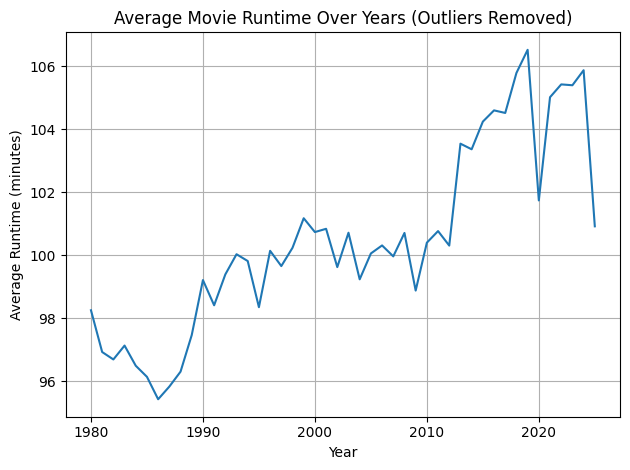

In [25]:
# IOR 밖 이상치 제거 helper 함수
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

# 연도별로 이상치 제거
filtered_df = movie_df[movie_df['Duration_minute'].notna()]
filtered_df = filtered_df.groupby('Year', group_keys=False).apply(lambda x: remove_outliers_iqr(x, 'Duration_minute'))

# 연도별 평균 상영시간
avg_movie_runtime_df = filtered_df.groupby('Year').agg(
    avg_runtime=('Duration_minute', 'mean')
).reset_index()

sns.lineplot(data=avg_movie_runtime_df, x="Year", y="avg_runtime")
plt.xlabel('Year')
plt.ylabel('Average Runtime (minutes)')
plt.title('Average Movie Runtime Over Years (Outliers Removed)')
plt.grid(True)
plt.tight_layout()
plt.show()

우상향 그래프인 것을 볼 수 있음

## 추세선 **

<Axes: xlabel='Year', ylabel='avg_runtime'>

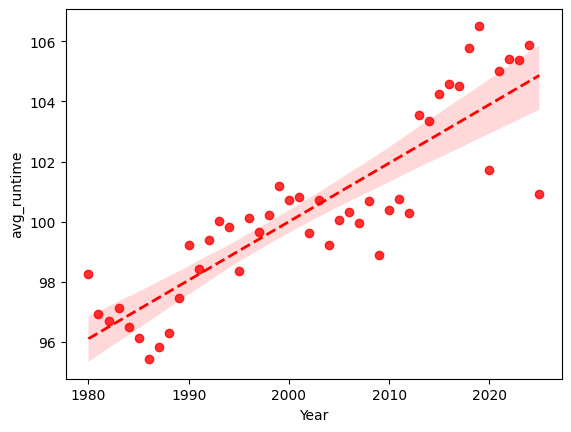

In [26]:
sns.regplot(data=avg_movie_runtime_df, x='Year',y='avg_runtime' ,scatter=True, color='red', line_kws={'linestyle': '--', 'linewidth': 2})

## 10년 단위 Box Plot (이상치 제외) **

C:\Users\Playdata\AppData\Local\Temp\ipykernel_23120\4219249787.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = filtered_df.groupby('Year', group_keys=False).apply(lambda x: remove_outliers_iqr(x, 'Duration_minute'))


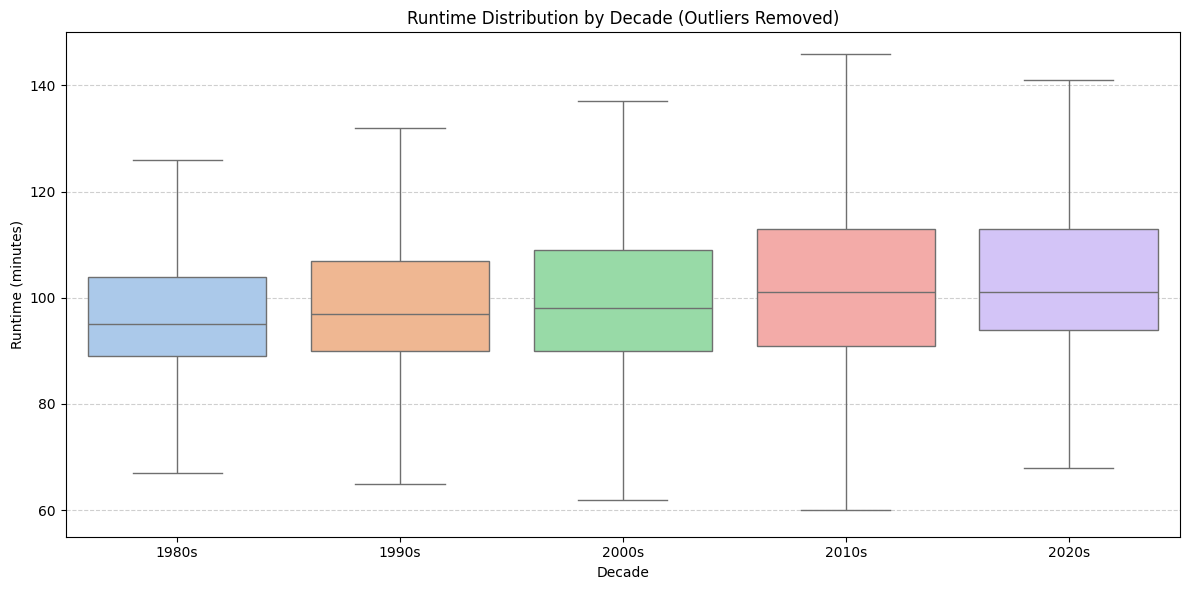

In [27]:
filtered_df = movie_df[movie_df['Duration_minute'].notna()].copy()
filtered_df = filtered_df.groupby('Year', group_keys=False).apply(lambda x: remove_outliers_iqr(x, 'Duration_minute'))

# 2. decade 컬럼 생성
filtered_df = filtered_df.copy()  # 경고 방지
filtered_df['decade'] = ((filtered_df['Year'] // 10) * 10).astype(str) + 's'

# 박스플롯
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=filtered_df,
    x='decade',
    y='Duration_minute',
    hue='decade',      # 추가
    legend=False,      # 범례 제거
    showfliers=False,
    palette='pastel'
)
plt.title('Runtime Distribution by Decade (Outliers Removed)')
plt.xlabel('Decade')
plt.ylabel('Runtime (minutes)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.ylim(55, 150)
plt.tight_layout()
plt.show()


우상향하는 추세선을 볼 수 있음

## 장르별 상영시간 (탑 5개 장르, 이상치 제거) **

C:\Users\Playdata\AppData\Local\Temp\ipykernel_23120\1273328419.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  genre_df_cleaned = genre_df.groupby('genres', group_keys=False).apply(lambda x: remove_outliers_iqr(x, 'Duration_minute'))


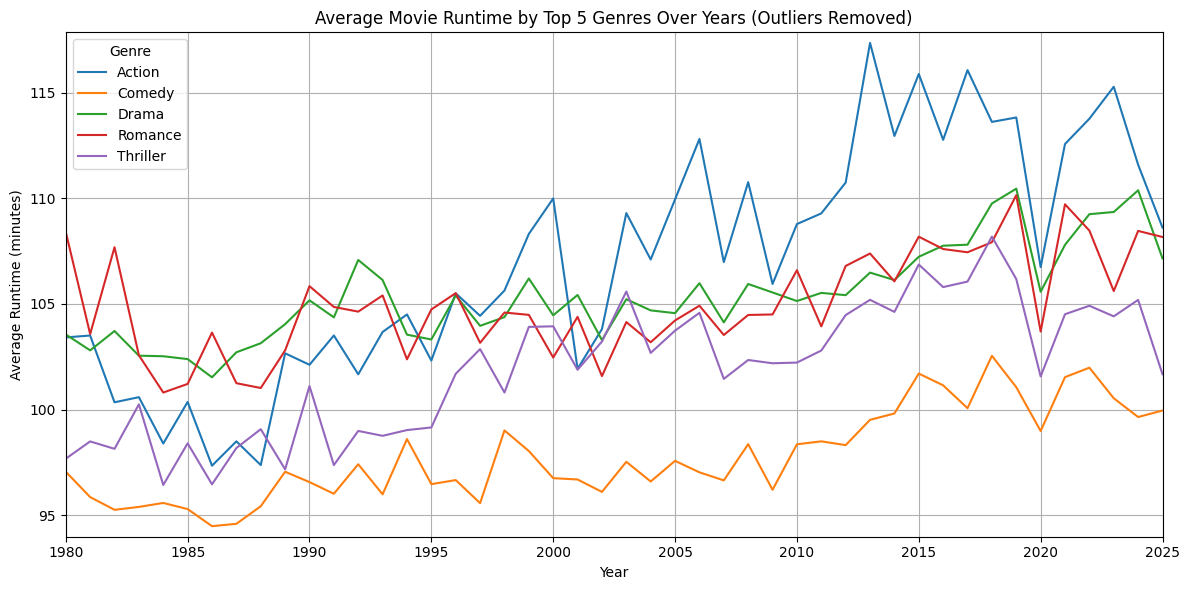

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 다중 장르 펼치기
genre_df = movie_df.explode('genres')

# IQR 기준으로 상영시간 이상치 제거
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

genre_df_cleaned = genre_df.groupby('genres', group_keys=False).apply(lambda x: remove_outliers_iqr(x, 'Duration_minute'))

# 연도랑 장르로 그룹핑
genre_year_avg = (
    genre_df_cleaned.groupby(['Year', 'genres'])['Duration_minute']
    .mean()
    .reset_index()
    .rename(columns={'genres': 'Genre', 'Duration_minute': 'avg_runtime'})
)

# 탑 5개 장르 선정 (빈도)
top_genres = genre_df['genres'].value_counts().head(5).index
filtered_df = genre_year_avg[genre_year_avg['Genre'].isin(top_genres)]

# Plot 
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_df, x='Year', y='avg_runtime', hue='Genre')
plt.title('Average Movie Runtime by Top 5 Genres Over Years (Outliers Removed)')
plt.xlabel('Year')
plt.xlim(1980, 2025)
plt.ylim(filtered_df['avg_runtime'].min() -0.5, filtered_df['avg_runtime'].max()+0.5)
plt.ylabel('Average Runtime (minutes)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 장르별 추세선

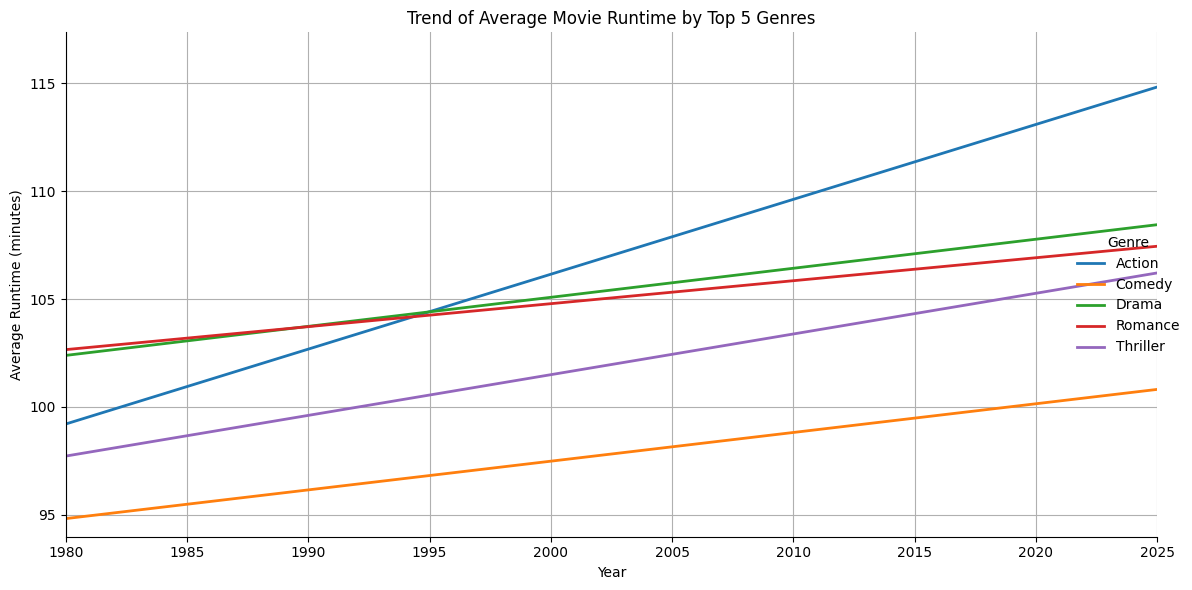

In [29]:
sns.lmplot(
    data=filtered_df,
    x='Year',
    y='avg_runtime',
    hue='Genre',
    height=6,
    aspect=1.8,
    scatter=False,        # Don't show individual data points
    ci=None,              # Don't show confidence intervals
    line_kws={'lw': 2}    # Line width for regression lines
)

plt.title('Trend of Average Movie Runtime by Top 5 Genres')
plt.xlabel('Year')
plt.ylabel('Average Runtime (minutes)')
plt.xlim(1980, 2025)
plt.ylim(filtered_df['avg_runtime'].min() - 0.5, filtered_df['avg_runtime'].max())
plt.grid(True)
plt.tight_layout()
plt.show()


전부 우상향

- median 값이 점점 증가하는 것을 볼 수 있음
- IQR도 점점 위로 올라가는 것을 볼 수 있음

## 장르 & 상영시간 상관관계 확인

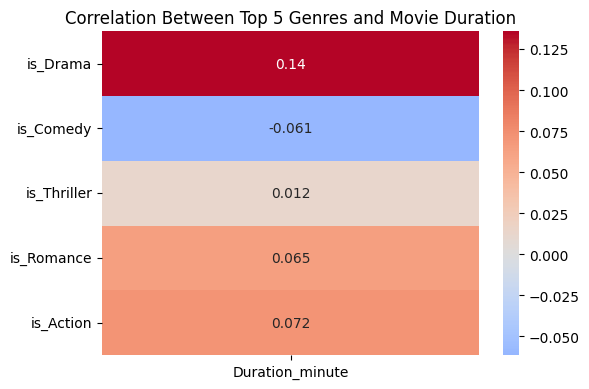

In [30]:
# Get top 5 genres by frequency
top_genres = genre_df['genres'].value_counts().head(5).index

# One-hot encode top genres
for genre in top_genres:
    movie_df[f'is_{genre}'] = movie_df['genres'].apply(lambda lst: genre in lst)

# Correlation matrix
columns_to_corr = [f'is_{genre}' for genre in top_genres] + ['Duration_minute']
corr_matrix = movie_df[columns_to_corr].corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix[['Duration_minute']].drop('Duration_minute'), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Top 5 Genres and Movie Duration')
plt.tight_layout()
plt.show()

관계 없어보임

## 탑 5개 장르별 상영시간 분산

C:\Users\Playdata\AppData\Local\Temp\ipykernel_23120\3861263159.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cleaned_top10_df = top_10_df.groupby('genres', group_keys=False).apply(remove_outliers_iqr)
C:\Users\Playdata\AppData\Local\Temp\ipykernel_23120\3861263159.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_variance.values, y=genre_variance.index, palette='crest')


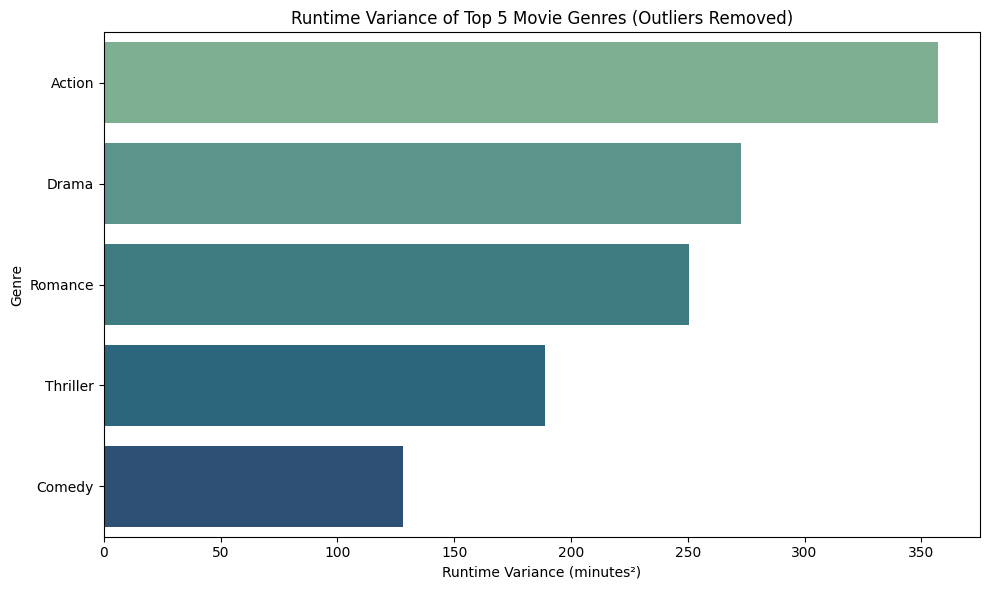

In [31]:
# 다중 장르 펼치기
genre_df = movie_df.copy()
genre_df = genre_df.explode('genres')

# 탑 5개 장르 선정
top_10_genres = genre_df['genres'].value_counts().head(5).index
top_10_df = genre_df[genre_df['genres'].isin(top_10_genres)]

# 상영시간 IQR 기준으로 이상치 제거해주는 함수
def remove_outliers_iqr(group):
    q1 = group['Duration_minute'].quantile(0.25)
    q3 = group['Duration_minute'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return group[(group['Duration_minute'] >= lower) & (group['Duration_minute'] <= upper)]

cleaned_top10_df = top_10_df.groupby('genres', group_keys=False).apply(remove_outliers_iqr)

# 장르별 분산으로 그룹핑
genre_variance = cleaned_top10_df.groupby('genres')['Duration_minute'].var().sort_values(ascending=False)

# Step 5: Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_variance.values, y=genre_variance.index, palette='crest')
plt.title('Runtime Variance of Top 5 Movie Genres (Outliers Removed)')
plt.xlabel('Runtime Variance (minutes²)')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

## 상영등급 별 상영시간 (탑 5개 상영등급, 이상치 제거) **

C:\Users\Playdata\AppData\Local\Temp\ipykernel_23120\1107029498.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = top_mpa_df.groupby('MPA', group_keys=False).apply(lambda x: remove_outliers_iqr(x, 'Duration_minute'))


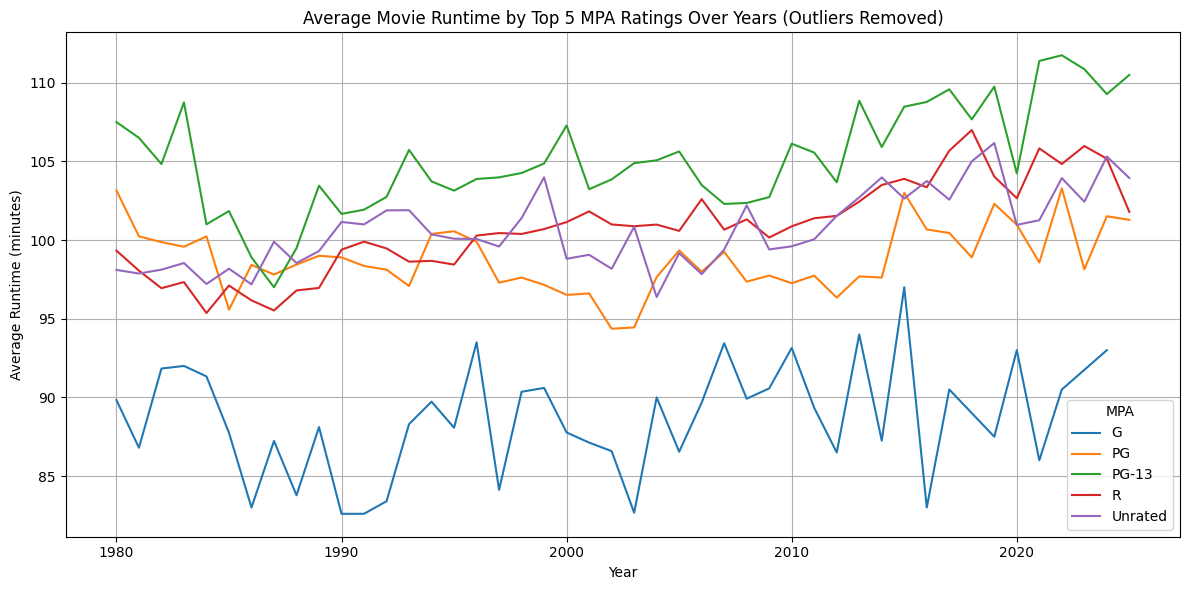

In [32]:
# Function to remove outliers using IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

# 탑5 등급
top_mpa = movie_df['MPA'].value_counts().head(5).index

# Filter for top 5 MPA
top_mpa_df = movie_df[movie_df['MPA'].isin(top_mpa) & movie_df['Duration_minute'].notna()]

# Apply outlier removal by MPA group
filtered_df = top_mpa_df.groupby('MPA', group_keys=False).apply(lambda x: remove_outliers_iqr(x, 'Duration_minute'))

# Group by Year and MPA to get average duration
mpa_avg_by_year = (
    filtered_df.groupby(['Year', 'MPA'])['Duration_minute']
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=mpa_avg_by_year, x='Year', y='Duration_minute', hue='MPA')
plt.title('Average Movie Runtime by Top 5 MPA Ratings Over Years (Outliers Removed)')
plt.ylabel('Average Runtime (minutes)')
plt.xlabel('Year')
plt.grid(True)
plt.tight_layout()

## 상영등급별  추세

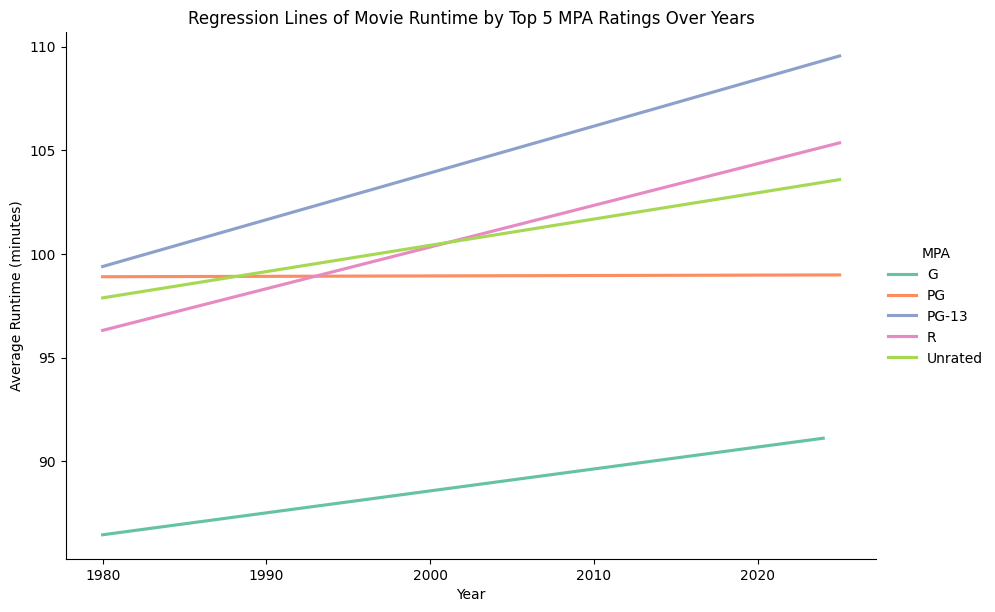

In [33]:
sns.lmplot(
    data=filtered_df,       
    x='Year', 
    y='Duration_minute', 
    hue='MPA',              
    height=6, 
    aspect=1.5, 
    markers='o',
    ci=None,                # turn off confidence interval if you prefer a cleaner look
    scatter=False,          # remove scatter dots for cleaner regression-only view
    palette='Set2'
)

plt.title('Regression Lines of Movie Runtime by Top 5 MPA Ratings Over Years')
plt.xlabel('Year')
plt.ylabel('Average Runtime (minutes)')
plt.show()

## 연도별 평균 예산 변화

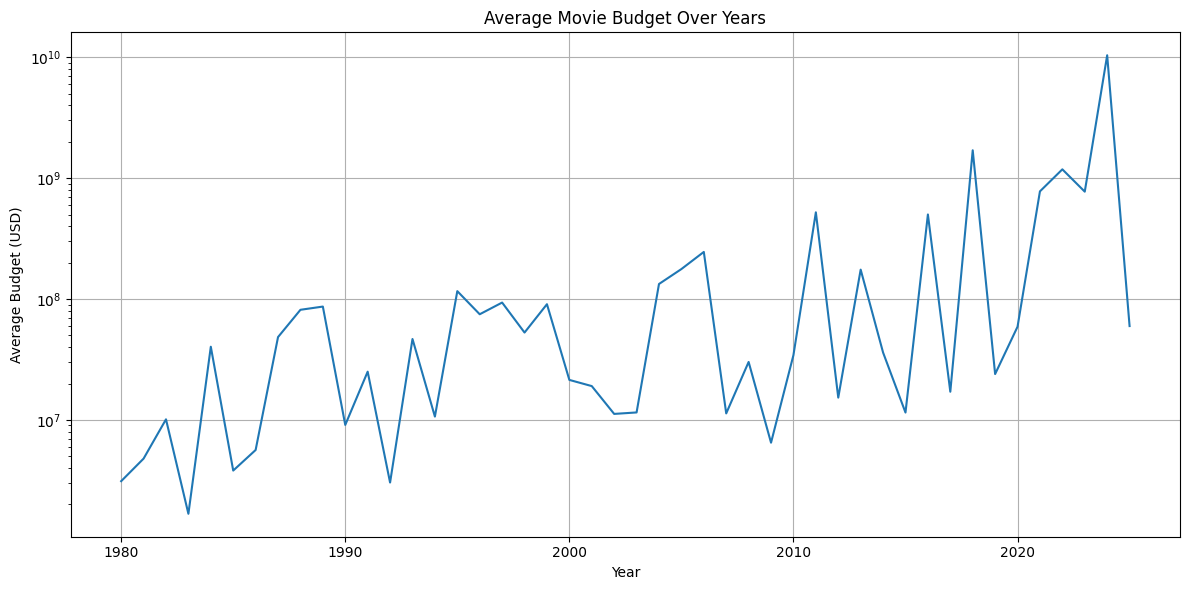

In [34]:
new_df = movie_df[(movie_df['budget'] > '0') & (movie_df['Duration_minute'].notnull())].copy()

# 2025년 7월 기준 환율 적용
rates = {
    'CAD': 1 / 1.36,       # 캐나다 달러 
    'GBP': 1 / 0.741,      # 영국 파운드 
    'EUR': 1 / 0.855,      # 유로 
    'INR': 1 / 86.38,      # 인도 루피 
    'PLN': 1 / 3.94,       # 폴란드 즈워티
    'MXN': 1 / 17.2,       # 멕시코 페소
    'ITL': 1 / 1936.27,    # 이탈리아 리라
    'FRF': 1 / 6.55957,    # 프랑스 프랑
    'USD': 1.0             # 미국 달러
}

# 변환 함수 정의
def convert_to_usd(budget_str):
    if pd.isna(budget_str):
        return np.nan
    budget_str = str(budget_str)
    
    # 통화기호와 숫자 추출
    match = re.search(r'(CA\$|A\$|US\$|\$|£|€|₹|PLN|MX\$|ITL|FRF)?\s*([\d,]+)', budget_str)
    if not match:
        return np.nan
    
    symbol, amount_str = match.groups()
    amount = float(amount_str.replace(',', ''))

    # 통화에 따라 USD로 환산
    if symbol == 'CA$':
        return amount * rates['CAD']
    elif symbol == 'A$':
        return amount * rates['CAD']  
    elif symbol in ('US$', '$', None):
        return amount * rates['USD']
    elif symbol == '£':
        return amount * rates['GBP']
    elif symbol == '€':
        return amount * rates['EUR']
    elif symbol == '₹':
        return amount * rates['INR']
    elif symbol == 'PLN':
        return amount * rates['PLN']
    elif symbol == 'MX$':
        return amount * rates['MXN']
    elif symbol == 'ITL':
        return amount * (1 / 1936.27) * rates['EUR']  
    elif symbol == 'FRF':
        return amount * (1 / 6.55957) * rates['EUR']  
    else:
        return np.nan

# 예산을 전부 USD로 변환하여 budget 컬럼으로 대체
new_df['budget'] = new_df['budget'].apply(convert_to_usd).round().astype('Int64')

# 연도로 그룹핑
avg_budget_by_year = new_df.groupby('Year')['budget'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_budget_by_year, x='Year', y='budget')
plt.yscale('log')  # Optional: Log scale helps if there's large variance
plt.title('Average Movie Budget Over Years')
plt.xlabel('Year')
plt.ylabel('Average Budget (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()


## 장르별 평균 예산 변화

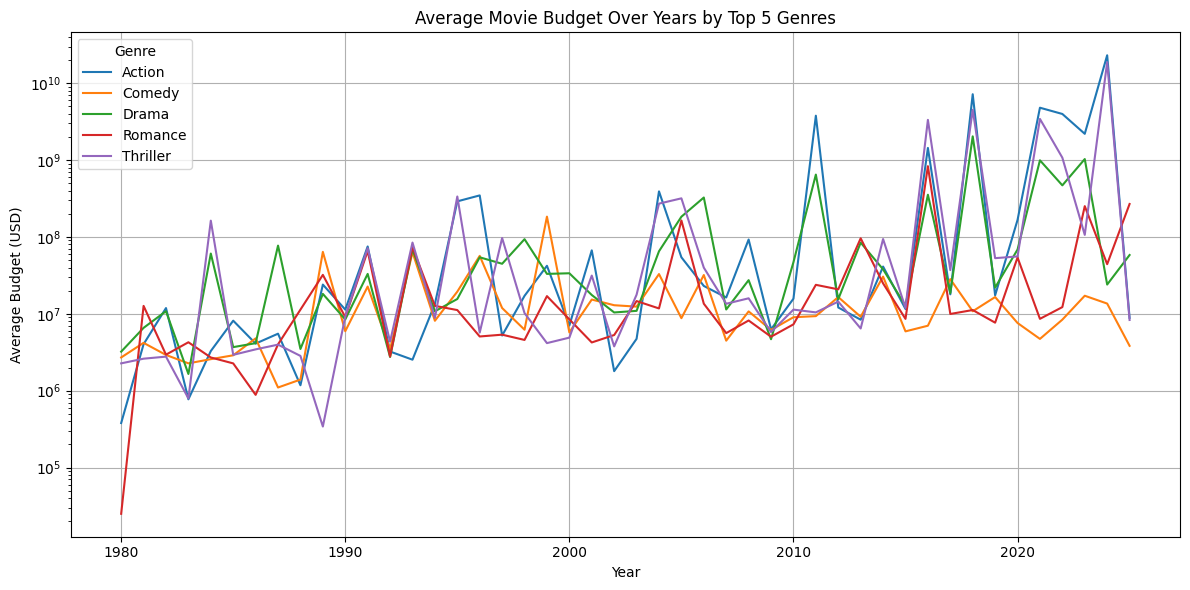

In [35]:
# USD로 바꾸기
genre_df = movie_df[(movie_df['budget'] > '0') & (movie_df['Duration_minute'].notnull())].copy()
genre_df['budget'] = genre_df['budget'].apply(convert_to_usd)

# 다중 장르 하나로 펼치기
genre_df = genre_df.explode('genres')

# 이름 바꾸기
genre_df.rename(columns={'genres': 'Genre'}, inplace=True)

# 탑 5 장르
top_genres = genre_df['Genre'].value_counts().head(5).index
genre_df = genre_df[genre_df['Genre'].isin(top_genres)]

""" 
# Step 4: Remove outliers by genre using IQR
def remove_outliers_iqr_grouped(df, column, group_col):
    return df.groupby(group_col, group_keys=False).apply(lambda x: remove_outliers_iqr(x, column))

filtered_df = remove_outliers_iqr_grouped(genre_df, 'budget', 'Genre')

"""

# 연도 장르 그룹핑
avg_budget_by_genre = (
    genre_df.groupby(['Year', 'Genre'])['budget']
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_budget_by_genre, x='Year', y='budget', hue='Genre')
plt.yscale('log')  # Optional: remove this if not needed
plt.title('Average Movie Budget Over Years by Top 5 Genres')
plt.xlabel('Year')
plt.ylabel('Average Budget (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

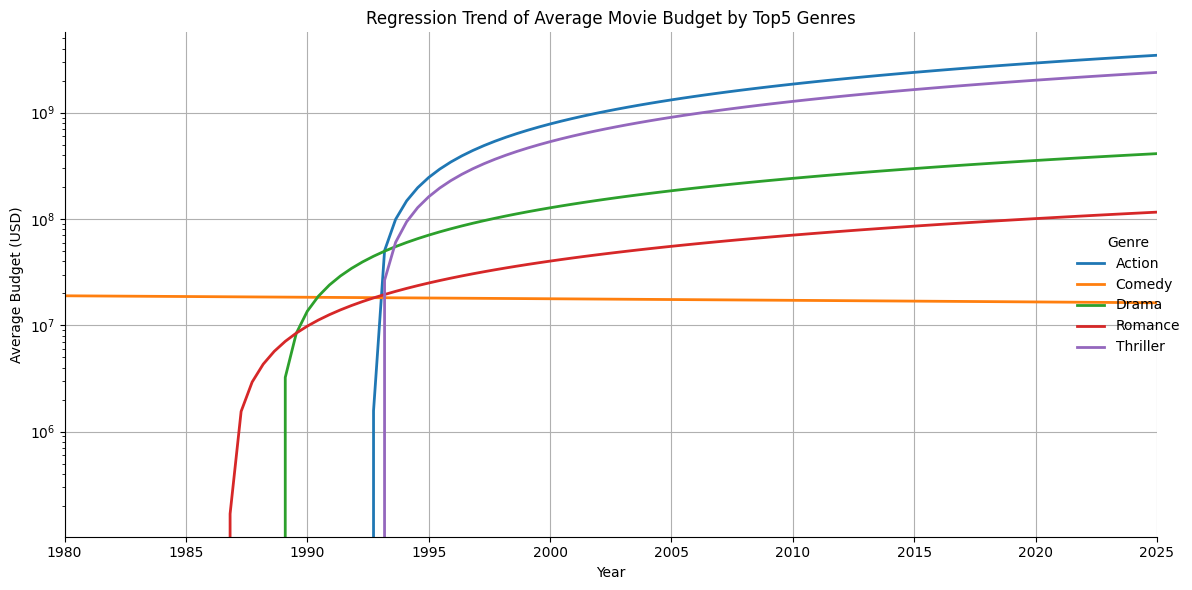

In [36]:
g = sns.lmplot(
    data=avg_budget_by_genre,
    x='Year',
    y='budget',
    hue='Genre',
    height=6,
    aspect=1.8,
    scatter=False,     
    ci=None,              
    line_kws={'lw': 2}  
)

plt.yscale('log')  # 로그스케일
plt.title('Regression Trend of Average Movie Budget by Top5 Genres')
plt.xlabel('Year')
plt.ylabel('Average Budget (USD)')
plt.xlim(1980, 2025)
plt.grid(True)
plt.tight_layout()
plt.show()


## 국가별 상영시간 (탑 5개 국가)

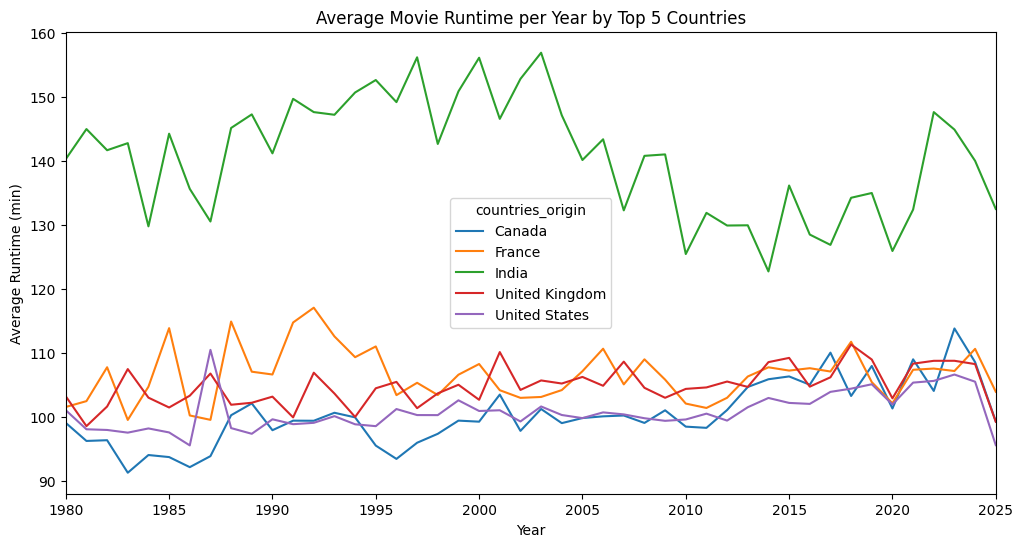

In [37]:
# 장르가 여러개인 영화의 장르들을 풀기
country_df = movie_df.explode('countries_origin')

# 연도와 장르로 그룹핑한 새 dataframe
avg_runtime_by_country_year = country_df.groupby(['countries_origin', 'Year'])['Duration_minute'].mean().reset_index()
avg_runtime_by_country_year.rename(columns={'Duration_minute': 'avg_runtime'}, inplace=True)


# 가장 많은 5개 장르 추출
top_countries = country_df['countries_origin'].value_counts().head(5).index

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=avg_runtime_by_country_year[avg_runtime_by_country_year['countries_origin'].isin(top_countries)],
    x='Year',
    y='avg_runtime',
    hue='countries_origin'
)
plt.title("Average Movie Runtime per Year by Top 5 Countries")
plt.ylabel("Average Runtime (min)")
plt.xlim(1980,2025)
plt.show()